In [1]:
import time
import numpy as np
import pandas as pd
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [2]:
data_path = '../rawdata/'

# 导入原始数据，预处理

In [3]:
air_reserve = pd.read_csv(data_path + 'air_reserve.csv').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv(data_path + 'hpg_reserve.csv').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv(data_path + 'air_store_info.csv').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv(data_path + 'hpg_store_info.csv').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv(data_path + 'air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
#以HPG的ID为索引
store_id_map = pd.read_csv(data_path + 'store_id_relation.csv').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv(data_path + 'date_info.csv').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [4]:
#就餐日期，预定日期，周几
submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek

In [5]:
#与submission保持一致，目的？
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']

In [6]:
#更新HPG餐厅ID
#store_id_map['air_store_id'] 为关联表中列名AIR ID，索引为HPG ID的Series。 通过map，将hpg_reserve的餐厅ID从HPG ID映射为AIR ID
#对于那些没有对应AIR ID 的餐厅，仍然使用HPG ID
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])

In [7]:
#同上逻辑，彻底抹去HPG的概念
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)

In [8]:
#对训练集和测试集进行同样的处理，因此合并
data = pd.concat([air_visit, submission]).copy()

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [9]:
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek

In [10]:
data.head()

,id,store_id,visit_date,visitors,dow
0,air_ba937bf13d40fb24_2016-01-13,air_ba937bf13d40fb24,2016-01-13,25,2
1,air_ba937bf13d40fb24_2016-01-14,air_ba937bf13d40fb24,2016-01-14,32,3
2,air_ba937bf13d40fb24_2016-01-15,air_ba937bf13d40fb24,2016-01-15,29,4
3,air_ba937bf13d40fb24_2016-01-16,air_ba937bf13d40fb24,2016-01-16,22,5
4,air_ba937bf13d40fb24_2016-01-18,air_ba937bf13d40fb24,2016-01-18,6,0


In [11]:
date_info.head()

,visit_date,holiday_flg
0,2016-01-01,1
1,2016-01-02,1
2,2016-01-03,1
3,2016-01-04,0
4,2016-01-05,0


In [12]:
#holiday_flg2 指代周末或者节假日
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)

In [13]:
air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])

In [14]:
#对餐厅类型和地理位置进行类型编码
lbl = LabelEncoder()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])

In [15]:
data.head()

,id,store_id,visit_date,visitors,dow
0,air_ba937bf13d40fb24_2016-01-13,air_ba937bf13d40fb24,2016-01-13,25,2
1,air_ba937bf13d40fb24_2016-01-14,air_ba937bf13d40fb24,2016-01-14,32,3
2,air_ba937bf13d40fb24_2016-01-15,air_ba937bf13d40fb24,2016-01-15,29,4
3,air_ba937bf13d40fb24_2016-01-16,air_ba937bf13d40fb24,2016-01-16,22,5
4,air_ba937bf13d40fb24_2016-01-18,air_ba937bf13d40fb24,2016-01-18,6,0


In [16]:
# log（1+x)处理顾客数
data['visitors'] = np.log1p(data['visitors'])

In [17]:
#根据餐厅ID，将餐厅的详情融合到data中
data = data.merge(air_store,on='store_id',how='left')

In [18]:
#根据就餐日期，将日期的相关信息融合到data中
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2']], on=['visit_date'],how='left')

In [19]:
data

,id,store_id,visit_date,visitors,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,holiday_flg,holiday_flg2
0,air_ba937bf13d40fb24_2016-01-13,air_ba937bf13d40fb24,2016-01-13,3.258097,2,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
1,air_ba937bf13d40fb24_2016-01-14,air_ba937bf13d40fb24,2016-01-14,3.496508,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
2,air_ba937bf13d40fb24_2016-01-15,air_ba937bf13d40fb24,2016-01-15,3.401197,4,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
3,air_ba937bf13d40fb24_2016-01-16,air_ba937bf13d40fb24,2016-01-16,3.135494,5,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,1
4,air_ba937bf13d40fb24_2016-01-18,air_ba937bf13d40fb24,2016-01-18,1.945910,0,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
5,air_ba937bf13d40fb24_2016-01-19,air_ba937bf13d40fb24,2016-01-19,2.302585,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
6,air_ba937bf13d40fb24_2016-01-20,air_ba937bf13d40fb24,2016-01-20,3.465736,2,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
7,air_ba937bf13d40fb24_2016-01-21,air_ba937bf13d40fb24,2016-01-21,3.091042,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
8,air_ba937bf13d40fb24_2016-01-22,air_ba937bf13d40fb24,2016-01-22,2.944439,4,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
9,air_ba937bf13d40fb24_2016-01-23,air_ba937bf13d40fb24,2016-01-23,3.295837,5,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,1


# 工具函数

In [20]:
#合并集合
#集合中后置位的对象将覆盖前置位的对象在result中保存的内容
def concat(L):
    result = None
    for l in L:
        if result is None:
            result = l
        else:
            try:
                result[l.columns.tolist()] = l
            except:
                print(l.head())
    return result

In [21]:

def left_merge(data1,data2,on):
    if type(on) != list:
        on = [on]
    if (set(on) & set(data2.columns)) != set(on):
        data2_temp = data2.reset_index()
    else:
        data2_temp = data2.copy()
    columns = [f for f in data2.columns if f not in on]
    result = data1.merge(data2_temp,on=on,how='left')
    result = result[columns]
    return result

In [22]:
#输入起始日期以及天数增量，返回结束日期
def date_add_days(start_date, days):
    end_date = parse(start_date[:10]) + timedelta(days=days)
    end_date = end_date.strftime('%Y-%m-%d')
    return end_date

In [23]:
def make_feats(end_date,n_day):
    t0 = time.time()
    key = end_date,n_day
    print('data key为：{}'.format(key))
    print('add label')
    # 在周期内的日期上做各种特征
    label = get_label(end_date,n_day)

    print('make feature...')
    result = [label]
    # 增加历史1000、56、28、14天内的就餐人数stats作为特征
    result.append(get_store_visitor_feat(label, key, 1000))        # store features
    result.append(get_store_visitor_feat(label, key, 56))          # store features
    result.append(get_store_visitor_feat(label, key, 28))          # store features
    result.append(get_store_visitor_feat(label, key, 14))          # store features
    # 增加历史1000天内的加权就餐人数，0.985^（天数差异）
    result.append(get_store_exp_visitor_feat(label, key, 1000))    # store exp features
    # 增加历史1000、56、28、14天内的，按周几划分的就餐人数stats作为特征
    result.append(get_store_week_feat(label, key, 1000))           # store dow features
    result.append(get_store_week_feat(label, key, 56))             # store dow features
    result.append(get_store_week_feat(label, key, 28))             # store dow features
    result.append(get_store_week_feat(label, key, 14))             # store dow features
    # ？？？？？？？？？？？？？
    result.append(get_store_week_diff_feat(label, key, 58))       # store dow diff features
    result.append(get_store_week_diff_feat(label, key, 1000))      # store dow diff features
    # 增加历史1000天内的，按周几划分的就餐人数stats作为特征
    result.append(get_store_all_week_feat(label, key, 1000))       # store all week feat
    # 增加历史1000天内的，按周几划分的加权就餐人数stats作为特征
    result.append(get_store_week_exp_feat(label, key, 1000))       # store dow exp feat
    # 增加历史1000天内的，按是否为假日划分的就餐人数stats作为特征
    result.append(get_store_holiday_feat(label, key, 1000))        # store holiday feat
    # 增加历史1000、56、28天内的，按餐厅类型划分的就餐人数stats作为特征
    result.append(get_genre_visitor_feat(label, key, 1000))         # genre feature
    result.append(get_genre_visitor_feat(label, key, 56))           # genre feature
    result.append(get_genre_visitor_feat(label, key, 28))           # genre feature
    # 增加历史1000天内的，按餐厅类型划分的加权就餐人数stats作为特征
    result.append(get_genre_exp_visitor_feat(label, key, 1000))     # genre feature
    # 增加历史1000、56、28天内的，按餐厅类型以及周几划分的就餐人数stats作为特征
    result.append(get_genre_week_feat(label, key, 1000))            # genre dow feature
    result.append(get_genre_week_feat(label, key, 56))              # genre dow feature
    result.append(get_genre_week_feat(label, key, 28))              # genre dow feature
    # 增加历史1000天内的，按餐厅类型以及周几划分的加权就餐人数stats作为特征
    result.append(get_genre_week_exp_feat(label, key, 1000))        # genre dow exp feature
    # ？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？
    result.append(get_reserve_feat(label,key))                      # air_reserve
    # ？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？
    result.append(get_first_last_time(label,key,1000))             # first time and last time

    result.append(label)

    print('merge...')
    result = concat(result)

    result = second_feat(result)

    print('data shape：{}'.format(result.shape))
    print('spending {}s'.format(time.time() - t0))
    return result

# 自定义特征制作函数

In [24]:
def make_feats_custom(end_date,n_day):
    t0 = time.time()
    key = end_date,n_day
    print('data key为：{}'.format(key))
    print('add label')
    # 截取日期窗内的数据
    label = get_label(end_date,n_day)
    
    print('original label dimension:',label.shape)

    print('making feature...')
    result = [label]

    # 在截取的数据上做星期相关的特征
    result.append(get_store_week_feat(label, key, 1000))           # store dow features
    
    result.append(get_store_week_exp_feat(label, key, 1000))       # store dow exp feat
    
    result.append(get_store_exp_visitor_feat(label, key, 1000))    # store exp features
    
    
    
    print('merge...')
    result = concat(result)
    
    print('label with features made dimension:',result.shape)

#     result = second_feat(result)

    print('data shape：{}'.format(result.shape))
    print('spending {}s'.format(time.time() - t0))
    return result

In [25]:
# 输入周期起始日期以及周期天数，返回在此周期内数据（包括周期起始日期》，《就餐日期与周期起始日期的差异》，《就餐月份》
# 《就餐年份》，《3天前是否为假日1》、《3天前是否为假日2》。。。《1天后是否为假日1》、《1天后是否为假日2》等特征
def get_label(end_date,n_day):
    label_end_date = date_add_days(end_date, n_day)
    # 就餐日期在[开始日期，开始日期+区间天数)范围内的数据
    label = data[(data['visit_date'] < label_end_date) & (data['visit_date'] >= end_date)].copy()
    # 数据中增加《周期起始日期》列
    label['end_date'] = end_date
    # 数据中增加就餐日期与开始日期之间天数的差异《就餐日期与周期起始日期的差异》
    label['diff_of_day'] = label['visit_date'].apply(lambda x: diff_of_days(x,end_date))
    # 数据中增加《就餐月份》
    label['month'] = label['visit_date'].str[5:7].astype(int)
    # 数据中增加《就餐年份》
    label['year'] = label['visit_date'].str[:4].astype(int)
    # 以i=3为例，在数据中增加《3天前是否为假日1》、《3天前是否为假日2》列
    for i in [3,2,1,-1]:
        date_info_temp = date_info.copy()
        date_info_temp['visit_date'] = date_info_temp['visit_date'].apply(lambda x: date_add_days(x,i))
        date_info_temp.rename(columns={'holiday_flg':'ahead_holiday_{}'.format(i),'holiday_flg2':'ahead_holiday2_{}'.format(i)},inplace=True)
        label = label.merge(date_info_temp, on=['visit_date'],how='left')
    label = label.reset_index(drop=True)
    return label

In [26]:
# 计算前一个日期减去后一个日期的天数
def diff_of_days(day1, day2):
    days = (parse(day1[:10]) - parse(day2[:10])).days
    return days

In [27]:
# 输入日期到输入日期之前n_day的时间范围内就餐人数的stats
def get_store_visitor_feat(label, key, n_day):
    # 就餐人数特征提取的起始日期为周期起始日期的n_day前
    start_date = date_add_days(key[0],-n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    # 该日期范围内每个餐厅就餐人数的stats
    result = data_temp.groupby(['store_id'], as_index=False)['visitors'].agg({'store_min{}'.format(n_day): 'min',
                                                                             'store_mean{}'.format(n_day): 'mean',
                                                                             'store_median{}'.format(n_day): 'median',
                                                                             'store_max{}'.format(n_day): 'max',
                                                                             'store_count{}'.format(n_day): 'count',
                                                                             'store_std{}'.format(n_day): 'std',
                                                                             'store_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result

In [28]:
# 就餐人数增加权重，0.985^(天数差异)
def get_store_exp_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    # 日期权重为0.985^(天数差异)
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['store_id'], as_index=False)['visitors'].agg({'store_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['store_id'], as_index=False)['weight'].agg({'store_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['store_id'], how='left')
    result['store_exp_mean{}'.format(n_day)] = result['store_exp_mean{}'.format(n_day)]/result['store_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result

In [29]:
# 按周几划分的就餐人数stats
def get_store_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors'].agg({'store_dow_min{}'.format(n_day): 'min',
                                                                                     'store_dow_mean{}'.format(n_day): 'mean',
                                                                                     'store_dow_median{}'.format(n_day): 'median',
                                                                                     'store_dow_max{}'.format(n_day): 'max',
                                                                                     'store_dow_count{}'.format(n_day): 'count',
                                                                                     'store_dow_std{}'.format(n_day): 'std',
                                                                                     'store_dow_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['store_id', 'dow']).fillna(0)
    return result

In [30]:
# 需要继续研究！！！！！！！！！！！！！！！！！！！！！！！！！！
def get_store_week_diff_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.set_index(['store_id','visit_date'])['visitors'].unstack()
    result = result.diff(axis=1).iloc[:,1:]
    c = result.columns
    result['store_diff_mean'] = np.abs(result[c]).mean(axis=1)
    result['store_diff_std'] = result[c].std(axis=1)
    result['store_diff_max'] = result[c].max(axis=1)
    result['store_diff_min'] = result[c].min(axis=1)
    result = left_merge(label, result[['store_diff_mean', 'store_diff_std', 'store_diff_max', 'store_diff_min']],on=['store_id']).fillna(0)
    return result

In [31]:
# 与get_store_week_feat有何区别？
def get_store_all_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result_temp = data_temp.groupby(['store_id', 'dow'],as_index=False)['visitors'].agg({'store_dow_mean{}'.format(n_day): 'mean',
                                                                     'store_dow_median{}'.format(n_day): 'median',
                                                                     'store_dow_sum{}'.format(n_day): 'max',
                                                                     'store_dow_count{}'.format(n_day): 'count'})
    result = pd.DataFrame()
    for i in range(7):
        result_sub = result_temp[result_temp['dow']==i].copy()
        result_sub = result_sub.set_index('store_id')
        result_sub = result_sub.add_prefix(str(i))
        result_sub = left_merge(label, result_sub, on=['store_id']).fillna(0)
        result = pd.concat([result,result_sub],axis=1)
    return result

In [32]:
# 与周期起始日期天数差异的指数权重
def get_store_week_exp_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['visitors2'] = data_temp['visitors']
    result = None
    for i in [0.9,0.95,0.97,0.98,0.985,0.99,0.999,0.9999]:
        data_temp['weight'] = data_temp['visit_date'].apply(lambda x: i**x)
        data_temp['visitors1'] = data_temp['visitors'] * data_temp['weight']
        data_temp['visitors2'] = data_temp['visitors2'] * data_temp['weight']
        result1 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors1'].agg({'store_dow_exp_mean{}_{}'.format(n_day,i): 'sum'})
        result3 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors2'].agg({'store_dow_exp_mean2{}_{}'.format(n_day, i): 'sum'})
        result2 = data_temp.groupby(['store_id', 'dow'], as_index=False)['weight'].agg({'store_dow_exp_weight_sum{}_{}'.format(n_day,i): 'sum'})
        result_temp = result1.merge(result2, on=['store_id', 'dow'], how='left')
        result_temp = result_temp.merge(result3, on=['store_id', 'dow'], how='left')
        result_temp['store_dow_exp_mean{}_{}'.format(n_day,i)] = result_temp['store_dow_exp_mean{}_{}'.format(n_day,i)]/result_temp['store_dow_exp_weight_sum{}_{}'.format(n_day,i)]
        result_temp['store_dow_exp_mean2{}_{}'.format(n_day, i)] = result_temp[ 'store_dow_exp_mean2{}_{}'.format(n_day, i)]/result_temp['store_dow_exp_weight_sum{}_{}'.format(n_day, i)]
        if result is None:
            result = result_temp
        else:
            result = result.merge(result_temp,on=['store_id','dow'],how='left')
    result = left_merge(label, result, on=['store_id', 'dow']).fillna(0)
    return result

In [33]:
def get_store_holiday_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result1 = data_temp.groupby(['store_id', 'holiday_flg'], as_index=False)['visitors'].agg(
        {'store_holiday_min{}'.format(n_day): 'min',
         'store_holiday_mean{}'.format(n_day): 'mean',
         'store_holiday_median{}'.format(n_day): 'median',
         'store_holiday_max{}'.format(n_day): 'max',
         'store_holiday_count{}'.format(n_day): 'count',
         'store_holiday_std{}'.format(n_day): 'std',
         'store_holiday_skew{}'.format(n_day): 'skew'})
    result1 = left_merge(label, result1, on=['store_id', 'holiday_flg']).fillna(0)
    result2 = data_temp.groupby(['store_id', 'holiday_flg2'], as_index=False)['visitors'].agg(
        {'store_holiday2_min{}'.format(n_day): 'min',
         'store_holiday2_mean{}'.format(n_day): 'mean',
         'store_holiday2_median{}'.format(n_day): 'median',
         'store_holiday2_max{}'.format(n_day): 'max',
         'store_holiday2_count{}'.format(n_day): 'count',
         'store_holiday2_std{}'.format(n_day): 'std',
         'store_holiday2_skew{}'.format(n_day): 'skew'})
    result2 = left_merge(label, result2, on=['store_id', 'holiday_flg2']).fillna(0)
    result = pd.concat([result1, result2], axis=1)
    return result

In [34]:
def get_genre_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0],-n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['air_genre_name'], as_index=False)['visitors'].agg({'genre_min{}'.format(n_day): 'min',
                                                                             'genre_mean{}'.format(n_day): 'mean',
                                                                             'genre_median{}'.format(n_day): 'median',
                                                                             'genre_max{}'.format(n_day): 'max',
                                                                             'genre_count{}'.format(n_day): 'count',
                                                                             'genre_std{}'.format(n_day): 'std',
                                                                             'genre_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['air_genre_name']).fillna(0)
    return result

In [35]:
def get_genre_exp_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['air_genre_name'], as_index=False)['visitors'].agg({'genre_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['air_genre_name'], as_index=False)['weight'].agg({'genre_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['air_genre_name'], how='left')
    result['genre_exp_mean{}'.format(n_day)] = result['genre_exp_mean{}'.format(n_day)]/result['genre_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['air_genre_name']).fillna(0)
    return result

In [36]:
def get_genre_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['visitors'].agg({'genre_dow_min{}'.format(n_day): 'min',
                                                                                         'genre_dow_mean{}'.format(n_day): 'mean',
                                                                                         'genre_dow_median{}'.format(n_day): 'median',
                                                                                         'genre_dow_max{}'.format(n_day): 'max',
                                                                                         'genre_dow_count{}'.format(n_day): 'count',
                                                                                         'genre_dow_std{}'.format(n_day): 'std',
                                                                                         'genre_dow_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['air_genre_name', 'dow']).fillna(0)
    return result

In [37]:
def get_genre_week_exp_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['visitors'].agg({'genre_dow_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['weight'].agg({'genre_dow_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['air_genre_name', 'dow'], how='left')
    result['genre_dow_exp_mean{}'.format(n_day)] = result['genre_dow_exp_mean{}'.format(n_day)]/result['genre_dow_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['air_genre_name', 'dow']).fillna(0)
    return result

In [38]:
# air_reserve  
def get_reserve_feat(label,key):
    label_end_date = date_add_days(key[0], key[1])
    # 预约就餐日期在日期窗内，且预约日期在日期窗起始日期前
    air_reserve_temp = air_reserve[(air_reserve.visit_date >= key[0]) &             # key[0] 是'2017-04-23'
                                   (air_reserve.visit_date < label_end_date) &      # label_end_date 是'2017-05-31'
                                   (air_reserve.reserve_date < key[0])].copy()
    # 补充餐厅详情
    air_reserve_temp = air_reserve_temp.merge(air_store,on='store_id',how='left')
    # 增加《预约就餐日期-预约日期》列
    air_reserve_temp['diff_time'] = (pd.to_datetime(air_reserve['visit_datetime'])-pd.to_datetime(air_reserve['reserve_datetime'])).dt.days
    air_reserve_temp = air_reserve_temp.merge(air_store,on='store_id')
    # 根据餐厅ID和就餐日期划分，统计《预约就餐人数总和》和《预约就餐次数》
    air_result = air_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg(
        {'air_reserve_visitors': 'sum',
         'air_reserve_count': 'count'})
    # 根据餐厅ID和就餐日期划分，统计《预约就餐日期-预约日期平均值》
    air_store_diff_time_mean = air_reserve_temp.groupby(['store_id', 'visit_date'])['diff_time'].agg(
        {'air_store_diff_time_mean': 'mean'})
    # 根据就餐日期划分，统计《所有餐厅预约就餐日期-预约日期平均值》
    air_diff_time_mean = air_reserve_temp.groupby(['visit_date'])['diff_time'].agg(
        {'air_diff_time_mean': 'mean'})
    # 根据餐厅ID和就餐日期划分，且所以餐厅ID的所有就餐日期都存在。实际不存在的NaN用0替代
    air_result = air_result.unstack().fillna(0).stack()
    air_date_result = air_reserve_temp.groupby(['visit_date'])['reserve_visitors'].agg({
        'air_date_visitors': 'sum',
        'air_date_count': 'count'})
    # 同样逻辑处理HPG系统
    hpg_reserve_temp = hpg_reserve[(hpg_reserve.visit_date >= key[0]) & (hpg_reserve.visit_date < label_end_date) & (hpg_reserve.reserve_date < key[0])].copy()
    hpg_reserve_temp['diff_time'] = (pd.to_datetime(hpg_reserve['visit_datetime']) - pd.to_datetime(hpg_reserve['reserve_datetime'])).dt.days
    hpg_result = hpg_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg({'hpg_reserve_visitors': 'sum',
                                                                                               'hpg_reserve_count': 'count'})
    hpg_result = hpg_result.unstack().fillna(0).stack()
    hpg_date_result = hpg_reserve_temp.groupby(['visit_date'])['reserve_visitors'].agg({
        'hpg_date_visitors': 'sum',
        'hpg_date_count': 'count'})
    hpg_store_diff_time_mean = hpg_reserve_temp.groupby(['store_id', 'visit_date'])['diff_time'].agg(
        {'hpg_store_diff_time_mean': 'mean'})
    hpg_diff_time_mean = hpg_reserve_temp.groupby(['visit_date'])['diff_time'].agg(
        {'hpg_diff_time_mean': 'mean'})
    air_result = left_merge(label, air_result, on=['store_id','visit_date']).fillna(0)
    air_store_diff_time_mean = left_merge(label, air_store_diff_time_mean, on=['store_id', 'visit_date']).fillna(0)
    hpg_result = left_merge(label, hpg_result, on=['store_id', 'visit_date']).fillna(0)
    hpg_store_diff_time_mean = left_merge(label, hpg_store_diff_time_mean, on=['store_id', 'visit_date']).fillna(0)
    air_date_result = left_merge(label, air_date_result, on=['visit_date']).fillna(0)
    air_diff_time_mean = left_merge(label, air_diff_time_mean, on=['visit_date']).fillna(0)
    hpg_date_result = left_merge(label, hpg_date_result, on=['visit_date']).fillna(0)
    hpg_diff_time_mean = left_merge(label, hpg_diff_time_mean, on=['visit_date']).fillna(0)
    result = pd.concat([air_result,hpg_result,air_date_result,hpg_date_result,air_store_diff_time_mean,
                        hpg_store_diff_time_mean,air_diff_time_mean,hpg_diff_time_mean],axis=1)
    return result

In [39]:
# ？？？？？？？？？？？？？？？？？？？
def get_first_last_time(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp = data_temp.sort_values('visit_date')
    result = data_temp.groupby('store_id')['visit_date'].agg({'first_time':lambda x: diff_of_days(key[0],np.min(x)),
                                                              'last_time':lambda x: diff_of_days(key[0],np.max(x)),})
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result

In [40]:
# second feature
def second_feat(result):
    result['store_mean_14_28_rate'] = result['store_mean14']/(result['store_mean28']+0.01)
    result['store_mean_28_56_rate'] = result['store_mean28'] / (result['store_mean56'] + 0.01)
    result['store_mean_56_1000_rate'] = result['store_mean56'] / (result['store_mean1000'] + 0.01)
    result['genre_mean_28_56_rate'] = result['genre_mean28'] / (result['genre_mean56'] + 0.01)
    result['sgenre_mean_56_1000_rate'] = result['genre_mean56'] / (result['genre_mean1000'] + 0.01)
    return result

In [41]:
def score(df):
    return np.sqrt(mean_squared_error(df['visitors'],df['preds']))
    

# 开始训练

In [42]:
import datetime
import lightgbm as lgb

In [55]:
# test_feat = make_feats_custom(start_date,39)
start_date = '2017-03-12'
train_start_date = date_add_days(start_date,-39)

In [44]:
params = {
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.7,
    'num_leaves': 60,
    'min_data': 100,
    'min_hessian': 1,
    'verbose': -1,
}

In [56]:
def score_of_window_num(window_num):
    
    train_feat = pd.DataFrame()
    print('producing test_feat...')
    test_feat = make_feats_custom(start_date,39)
    print('test_feat has been produced')

    print('producing train_feat...')
    for i in range(window_num+1):
        train_feat_sub = make_feats_custom(date_add_days(train_start_date, i*(-7)),39)
        train_feat = pd.concat([train_feat,train_feat_sub])
    print('train_feat has been produced')
    
    
    predictors = [f for f in test_feat.columns if f not in (['id','store_id','visit_date','end_date','air_area_name','visitors','month'])]


    t0 = time.time()
    lgb_train = lgb.Dataset(train_feat[predictors], train_feat['visitors'])
    lgb_test = lgb.Dataset(test_feat[predictors], test_feat['visitors'])

    gbm = lgb.train(params,lgb_train,2300)
    pred = gbm.predict(test_feat[predictors])

    print('训练用时{}秒'.format(time.time() - t0))
    
    cv=test_feat.copy()
    cv['preds']=pred
    return score(cv)



    
    
    
    
    
        

In [62]:
def score_versus_window_num_record(num):
    
    window_num_list=[]
    score_list=[]
    for i in range(num+1):
        score_list.append(score_of_window_num(i))
        window_num_list.append(i)
    record=pd.DataFrame({'window_num':window_num_list,'score':score_list})
    return record
        
        
        

In [60]:
score_record=score_versus_window_num_record(58)
score_record

producing test_feat...
data key为：('2017-03-12', 39)
add label
original label dimension: (27728, 24)
making feature...
merge...
label with features made dimension: (27728, 57)
data shape：(27728, 57)
spending 46.781890869140625s
test_feat has been produced
producing train_feat...
data key为：('2017-02-01', 39)
add label
original label dimension: (27838, 24)
making feature...
merge...
label with features made dimension: (27838, 57)
data shape：(27838, 57)
spending 41.008270263671875s
train_feat has been produced
训练用时10.739239692687988秒
producing test_feat...
data key为：('2017-03-12', 39)
add label
original label dimension: (27728, 24)
making feature...
merge...
label with features made dimension: (27728, 57)
data shape：(27728, 57)
spending 45.89224028587341s
test_feat has been produced
producing train_feat...
data key为：('2017-02-01', 39)
add label
original label dimension: (27838, 24)
making feature...
merge...
label with features made dimension: (27838, 57)
data shape：(27838, 57)
spending 40

original label dimension: (27838, 24)
making feature...
merge...
label with features made dimension: (27838, 57)
data shape：(27838, 57)
spending 40.396944761276245s
data key为：('2017-01-25', 39)
add label
original label dimension: (27826, 24)
making feature...
merge...
label with features made dimension: (27826, 57)
data shape：(27826, 57)
spending 39.669883012771606s
data key为：('2017-01-18', 39)
add label
original label dimension: (27751, 24)
making feature...
merge...
label with features made dimension: (27751, 57)
data shape：(27751, 57)
spending 38.559852838516235s
data key为：('2017-01-11', 39)
add label
original label dimension: (27681, 24)
making feature...
merge...
label with features made dimension: (27681, 57)
data shape：(27681, 57)
spending 37.727081060409546s
data key为：('2017-01-04', 39)
add label
original label dimension: (27003, 24)
making feature...
merge...
label with features made dimension: (27003, 57)
data shape：(27003, 57)
spending 36.85039162635803s
data key为：('2016-12-

data key为：('2016-11-30', 39)
add label
original label dimension: (25298, 24)
making feature...
merge...
label with features made dimension: (25298, 57)
data shape：(25298, 57)
spending 32.501057624816895s
data key为：('2016-11-23', 39)
add label
original label dimension: (27088, 24)
making feature...
merge...
label with features made dimension: (27088, 57)
data shape：(27088, 57)
spending 31.813899278640747s
train_feat has been produced
训练用时33.62006592750549秒
producing test_feat...
data key为：('2017-03-12', 39)
add label
original label dimension: (27728, 24)
making feature...
merge...
label with features made dimension: (27728, 57)
data shape：(27728, 57)
spending 46.065775632858276s
test_feat has been produced
producing train_feat...
data key为：('2017-02-01', 39)
add label
original label dimension: (27838, 24)
making feature...
merge...
label with features made dimension: (27838, 57)
data shape：(27838, 57)
spending 40.669211626052856s
data key为：('2017-01-25', 39)
add label
original label dim

merge...
label with features made dimension: (25133, 57)
data shape：(25133, 57)
spending 33.54925203323364s
data key为：('2016-11-30', 39)
add label
original label dimension: (25298, 24)
making feature...
merge...
label with features made dimension: (25298, 57)
data shape：(25298, 57)
spending 32.80022931098938s
data key为：('2016-11-23', 39)
add label
original label dimension: (27088, 24)
making feature...
merge...
label with features made dimension: (27088, 57)
data shape：(27088, 57)
spending 31.8328218460083s
data key为：('2016-11-16', 39)
add label
original label dimension: (27723, 24)
making feature...
merge...
label with features made dimension: (27723, 57)
data shape：(27723, 57)
spending 31.045987129211426s
data key为：('2016-11-09', 39)
add label
original label dimension: (27638, 24)
making feature...
merge...
label with features made dimension: (27638, 57)
data shape：(27638, 57)
spending 29.97282385826111s
data key为：('2016-11-02', 39)
add label
original label dimension: (27448, 24)
mak

original label dimension: (27728, 24)
making feature...
merge...
label with features made dimension: (27728, 57)
data shape：(27728, 57)
spending 46.009926319122314s
test_feat has been produced
producing train_feat...
data key为：('2017-02-01', 39)
add label
original label dimension: (27838, 24)
making feature...
merge...
label with features made dimension: (27838, 57)
data shape：(27838, 57)
spending 40.733070611953735s
data key为：('2017-01-25', 39)
add label
original label dimension: (27826, 24)
making feature...
merge...
label with features made dimension: (27826, 57)
data shape：(27826, 57)
spending 39.757649183273315s
data key为：('2017-01-18', 39)
add label
original label dimension: (27751, 24)
making feature...
merge...
label with features made dimension: (27751, 57)
data shape：(27751, 57)
spending 38.75433278083801s
data key为：('2017-01-11', 39)
add label
original label dimension: (27681, 24)
making feature...
merge...
label with features made dimension: (27681, 57)
data shape：(27681, 5

original label dimension: (27826, 24)
making feature...
merge...
label with features made dimension: (27826, 57)
data shape：(27826, 57)
spending 39.8025004863739s
data key为：('2017-01-18', 39)
add label
original label dimension: (27751, 24)
making feature...
merge...
label with features made dimension: (27751, 57)
data shape：(27751, 57)
spending 38.85107398033142s
data key为：('2017-01-11', 39)
add label
original label dimension: (27681, 24)
making feature...
merge...
label with features made dimension: (27681, 57)
data shape：(27681, 57)
spending 37.9525203704834s
data key为：('2017-01-04', 39)
add label
original label dimension: (27003, 24)
making feature...
merge...
label with features made dimension: (27003, 57)
data shape：(27003, 57)
spending 37.043893337249756s
data key为：('2016-12-28', 39)
add label
original label dimension: (24997, 24)
making feature...
merge...
label with features made dimension: (24997, 57)
data shape：(24997, 57)
spending 36.340787410736084s
data key为：('2016-12-21',

merge...
label with features made dimension: (27728, 57)
data shape：(27728, 57)
spending 45.91617703437805s
test_feat has been produced
producing train_feat...
data key为：('2017-02-01', 39)
add label
original label dimension: (27838, 24)
making feature...
merge...
label with features made dimension: (27838, 57)
data shape：(27838, 57)
spending 40.62832069396973s
data key为：('2017-01-25', 39)
add label
original label dimension: (27826, 24)
making feature...
merge...
label with features made dimension: (27826, 57)
data shape：(27826, 57)
spending 39.837435245513916s
data key为：('2017-01-18', 39)
add label
original label dimension: (27751, 24)
making feature...
merge...
label with features made dimension: (27751, 57)
data shape：(27751, 57)
spending 38.81717586517334s
data key为：('2017-01-11', 39)
add label
original label dimension: (27681, 24)
making feature...
merge...
label with features made dimension: (27681, 57)
data shape：(27681, 57)
spending 37.85573720932007s
data key为：('2017-01-04', 39

data key为：('2016-10-05', 39)
add label
original label dimension: (27310, 24)
making feature...
merge...
label with features made dimension: (27310, 57)
data shape：(27310, 57)
spending 25.267375230789185s
data key为：('2016-09-28', 39)
add label
original label dimension: (27303, 24)
making feature...
merge...
label with features made dimension: (27303, 57)
data shape：(27303, 57)
spending 24.358840465545654s
data key为：('2016-09-21', 39)
add label
original label dimension: (27270, 24)
making feature...
merge...
label with features made dimension: (27270, 57)
data shape：(27270, 57)
spending 23.515069246292114s
data key为：('2016-09-14', 39)
add label
original label dimension: (27111, 24)
making feature...
merge...
label with features made dimension: (27111, 57)
data shape：(27111, 57)
spending 22.617512702941895s
data key为：('2016-09-07', 39)
add label
original label dimension: (27091, 24)
making feature...
merge...
label with features made dimension: (27091, 57)
data shape：(27091, 57)
spending 

original label dimension: (25298, 24)
making feature...
merge...
label with features made dimension: (25298, 57)
data shape：(25298, 57)
spending 33.04161238670349s
data key为：('2016-11-23', 39)
add label
original label dimension: (27088, 24)
making feature...
merge...
label with features made dimension: (27088, 57)
data shape：(27088, 57)
spending 32.17792534828186s
data key为：('2016-11-16', 39)
add label
original label dimension: (27723, 24)
making feature...
merge...
label with features made dimension: (27723, 57)
data shape：(27723, 57)
spending 31.53165364265442s
data key为：('2016-11-09', 39)
add label
original label dimension: (27638, 24)
making feature...
merge...
label with features made dimension: (27638, 57)
data shape：(27638, 57)
spending 30.4715256690979s
data key为：('2016-11-02', 39)
add label
original label dimension: (27448, 24)
making feature...
merge...
label with features made dimension: (27448, 57)
data shape：(27448, 57)
spending 29.455209016799927s
data key为：('2016-10-26',

data key为：('2016-08-17', 39)
add label
original label dimension: (26923, 24)
making feature...
merge...
label with features made dimension: (26923, 57)
data shape：(26923, 57)
spending 19.15276551246643s
train_feat has been produced
训练用时66.02139401435852秒
producing test_feat...
data key为：('2017-03-12', 39)
add label
original label dimension: (27728, 24)
making feature...
merge...
label with features made dimension: (27728, 57)
data shape：(27728, 57)
spending 46.47170352935791s
test_feat has been produced
producing train_feat...
data key为：('2017-02-01', 39)
add label
original label dimension: (27838, 24)
making feature...
merge...
label with features made dimension: (27838, 57)
data shape：(27838, 57)
spending 41.3513867855072s
data key为：('2017-01-25', 39)
add label
original label dimension: (27826, 24)
making feature...
merge...
label with features made dimension: (27826, 57)
data shape：(27826, 57)
spending 40.14860510826111s
data key为：('2017-01-18', 39)
add label
original label dimensio

original label dimension: (27088, 24)
making feature...
merge...
label with features made dimension: (27088, 57)
data shape：(27088, 57)
spending 32.18689036369324s
data key为：('2016-11-16', 39)
add label
original label dimension: (27723, 24)
making feature...
merge...
label with features made dimension: (27723, 57)
data shape：(27723, 57)
spending 31.57254409790039s
data key为：('2016-11-09', 39)
add label
original label dimension: (27638, 24)
making feature...
merge...
label with features made dimension: (27638, 57)
data shape：(27638, 57)
spending 30.52634358406067s
data key为：('2016-11-02', 39)
add label
original label dimension: (27448, 24)
making feature...
merge...
label with features made dimension: (27448, 57)
data shape：(27448, 57)
spending 29.500088930130005s
data key为：('2016-10-26', 39)
add label
original label dimension: (27426, 24)
making feature...
merge...
label with features made dimension: (27426, 57)
data shape：(27426, 57)
spending 28.53367304801941s
data key为：('2016-10-19'

data key为：('2016-08-31', 39)
add label
original label dimension: (27157, 24)
making feature...
merge...
label with features made dimension: (27157, 57)
data shape：(27157, 57)
spending 20.90708088874817s
data key为：('2016-08-24', 39)
add label
original label dimension: (27121, 24)
making feature...
merge...
label with features made dimension: (27121, 57)
data shape：(27121, 57)
spending 19.927693605422974s
data key为：('2016-08-17', 39)
add label
original label dimension: (26923, 24)
making feature...
merge...
label with features made dimension: (26923, 57)
data shape：(26923, 57)
spending 18.984192609786987s
data key为：('2016-08-10', 39)
add label
original label dimension: (26518, 24)
making feature...
merge...
label with features made dimension: (26518, 57)
data shape：(26518, 57)
spending 18.169397354125977s
data key为：('2016-08-03', 39)
add label
original label dimension: (26465, 24)
making feature...
merge...
label with features made dimension: (26465, 57)
data shape：(26465, 57)
spending 1

original label dimension: (27751, 24)
making feature...
merge...
label with features made dimension: (27751, 57)
data shape：(27751, 57)
spending 39.07447671890259s
data key为：('2017-01-11', 39)
add label
original label dimension: (27681, 24)
making feature...
merge...
label with features made dimension: (27681, 57)
data shape：(27681, 57)
spending 38.159916639328s
data key为：('2017-01-04', 39)
add label
original label dimension: (27003, 24)
making feature...
merge...
label with features made dimension: (27003, 57)
data shape：(27003, 57)
spending 37.120705366134644s
data key为：('2016-12-28', 39)
add label
original label dimension: (24997, 24)
making feature...
merge...
label with features made dimension: (24997, 57)
data shape：(24997, 57)
spending 36.43151068687439s
data key为：('2016-12-21', 39)
add label
original label dimension: (24984, 24)
making feature...
merge...
label with features made dimension: (24984, 57)
data shape：(24984, 57)
spending 35.54192018508911s
data key为：('2016-12-14', 

data key为：('2016-11-16', 39)
add label
original label dimension: (27723, 24)
making feature...
merge...
label with features made dimension: (27723, 57)
data shape：(27723, 57)
spending 30.968124866485596s
data key为：('2016-11-09', 39)
add label
original label dimension: (27638, 24)
making feature...
merge...
label with features made dimension: (27638, 57)
data shape：(27638, 57)
spending 29.995761394500732s
data key为：('2016-11-02', 39)
add label
original label dimension: (27448, 24)
making feature...
merge...
label with features made dimension: (27448, 57)
data shape：(27448, 57)
spending 29.23180651664734s
data key为：('2016-10-26', 39)
add label
original label dimension: (27426, 24)
making feature...
merge...
label with features made dimension: (27426, 57)
data shape：(27426, 57)
spending 28.059942483901978s
data key为：('2016-10-19', 39)
add label
original label dimension: (27406, 24)
making feature...
merge...
label with features made dimension: (27406, 57)
data shape：(27406, 57)
spending 2

data key为：('2016-09-21', 39)
add label
original label dimension: (27270, 24)
making feature...
merge...
label with features made dimension: (27270, 57)
data shape：(27270, 57)
spending 23.434314012527466s
data key为：('2016-09-14', 39)
add label
original label dimension: (27111, 24)
making feature...
merge...
label with features made dimension: (27111, 57)
data shape：(27111, 57)
spending 22.546720266342163s
data key为：('2016-09-07', 39)
add label
original label dimension: (27091, 24)
making feature...
merge...
label with features made dimension: (27091, 57)
data shape：(27091, 57)
spending 21.604203462600708s
data key为：('2016-08-31', 39)
add label
original label dimension: (27157, 24)
making feature...
merge...
label with features made dimension: (27157, 57)
data shape：(27157, 57)
spending 20.772430896759033s
data key为：('2016-08-24', 39)
add label
original label dimension: (27121, 24)
making feature...
merge...
label with features made dimension: (27121, 57)
data shape：(27121, 57)
spending 

data key为：('2016-08-03', 39)
add label
original label dimension: (26465, 24)
making feature...
merge...
label with features made dimension: (26465, 57)
data shape：(26465, 57)
spending 17.345563650131226s
data key为：('2016-07-27', 39)
add label
original label dimension: (26493, 24)
making feature...
merge...
label with features made dimension: (26493, 57)
data shape：(26493, 57)
spending 16.29238510131836s
data key为：('2016-07-20', 39)
add label
original label dimension: (26478, 24)
making feature...
merge...
label with features made dimension: (26478, 57)
data shape：(26478, 57)
spending 15.330023527145386s
data key为：('2016-07-13', 39)
add label
original label dimension: (26457, 24)
making feature...
merge...
label with features made dimension: (26457, 57)
data shape：(26457, 57)
spending 14.423449754714966s
data key为：('2016-07-06', 39)
add label
original label dimension: (26935, 24)
making feature...
merge...
label with features made dimension: (26935, 57)
data shape：(26935, 57)
spending 1

data key为：('2016-06-22', 39)
add label
original label dimension: (23344, 24)
making feature...
merge...
label with features made dimension: (23344, 57)
data shape：(23344, 57)
spending 11.598973989486694s
data key为：('2016-06-15', 39)
add label
original label dimension: (20381, 24)
making feature...
merge...
label with features made dimension: (20381, 57)
data shape：(20381, 57)
spending 10.964670658111572s
train_feat has been produced
训练用时86.27820706367493秒
producing test_feat...
data key为：('2017-03-12', 39)
add label
original label dimension: (27728, 24)
making feature...
merge...
label with features made dimension: (27728, 57)
data shape：(27728, 57)
spending 46.1365852355957s
test_feat has been produced
producing train_feat...
data key为：('2017-02-01', 39)
add label
original label dimension: (27838, 24)
making feature...
merge...
label with features made dimension: (27838, 57)
data shape：(27838, 57)
spending 40.67024278640747s
data key为：('2017-01-25', 39)
add label
original label dimens

original label dimension: (27838, 24)
making feature...
merge...
label with features made dimension: (27838, 57)
data shape：(27838, 57)
spending 40.649263858795166s
data key为：('2017-01-25', 39)
add label
original label dimension: (27826, 24)
making feature...
merge...
label with features made dimension: (27826, 57)
data shape：(27826, 57)
spending 39.76462984085083s
data key为：('2017-01-18', 39)
add label
original label dimension: (27751, 24)
making feature...
merge...
label with features made dimension: (27751, 57)
data shape：(27751, 57)
spending 38.87402391433716s
data key为：('2017-01-11', 39)
add label
original label dimension: (27681, 24)
making feature...
merge...
label with features made dimension: (27681, 57)
data shape：(27681, 57)
spending 37.87469553947449s
data key为：('2017-01-04', 39)
add label
original label dimension: (27003, 24)
making feature...
merge...
label with features made dimension: (27003, 57)
data shape：(27003, 57)
spending 36.841450452804565s
data key为：('2016-12-28

original label dimension: (27681, 24)
making feature...
merge...
label with features made dimension: (27681, 57)
data shape：(27681, 57)
spending 37.94752097129822s
data key为：('2017-01-04', 39)
add label
original label dimension: (27003, 24)
making feature...
merge...
label with features made dimension: (27003, 57)
data shape：(27003, 57)
spending 37.271300315856934s
data key为：('2016-12-28', 39)
add label
original label dimension: (24997, 24)
making feature...
merge...
label with features made dimension: (24997, 57)
data shape：(24997, 57)
spending 36.311832904815674s
data key为：('2016-12-21', 39)
add label
original label dimension: (24984, 24)
making feature...
merge...
label with features made dimension: (24984, 57)
data shape：(24984, 57)
spending 35.406322956085205s
data key为：('2016-12-14', 39)
add label
original label dimension: (25056, 24)
making feature...
merge...
label with features made dimension: (25056, 57)
data shape：(25056, 57)
spending 34.40898680686951s
data key为：('2016-12-0

original label dimension: (24997, 24)
making feature...
merge...
label with features made dimension: (24997, 57)
data shape：(24997, 57)
spending 36.24604296684265s
data key为：('2016-12-21', 39)
add label
original label dimension: (24984, 24)
making feature...
merge...
label with features made dimension: (24984, 57)
data shape：(24984, 57)
spending 35.30655598640442s
data key为：('2016-12-14', 39)
add label
original label dimension: (25056, 24)
making feature...
merge...
label with features made dimension: (25056, 57)
data shape：(25056, 57)
spending 34.48378801345825s
data key为：('2016-12-07', 39)
add label
original label dimension: (25133, 24)
making feature...
merge...
label with features made dimension: (25133, 57)
data shape：(25133, 57)
spending 33.50437808036804s
data key为：('2016-11-30', 39)
add label
original label dimension: (25298, 24)
making feature...
merge...
label with features made dimension: (25298, 57)
data shape：(25298, 57)
spending 32.804213762283325s
data key为：('2016-11-23'

original label dimension: (24984, 24)
making feature...
merge...
label with features made dimension: (24984, 57)
data shape：(24984, 57)
spending 35.28464436531067s
data key为：('2016-12-14', 39)
add label
original label dimension: (25056, 24)
making feature...
merge...
label with features made dimension: (25056, 57)
data shape：(25056, 57)
spending 34.412935972213745s
data key为：('2016-12-07', 39)
add label
original label dimension: (25133, 24)
making feature...
merge...
label with features made dimension: (25133, 57)
data shape：(25133, 57)
spending 33.41062784194946s
data key为：('2016-11-30', 39)
add label
original label dimension: (25298, 24)
making feature...
merge...
label with features made dimension: (25298, 57)
data shape：(25298, 57)
spending 32.58979272842407s
data key为：('2016-11-23', 39)
add label
original label dimension: (27088, 24)
making feature...
merge...
label with features made dimension: (27088, 57)
data shape：(27088, 57)
spending 31.79295516014099s
data key为：('2016-11-16'

original label dimension: (24984, 24)
making feature...
merge...
label with features made dimension: (24984, 57)
data shape：(24984, 57)
spending 35.365426778793335s
data key为：('2016-12-14', 39)
add label
original label dimension: (25056, 24)
making feature...
merge...
label with features made dimension: (25056, 57)
data shape：(25056, 57)
spending 34.36212134361267s
data key为：('2016-12-07', 39)
add label
original label dimension: (25133, 24)
making feature...
merge...
label with features made dimension: (25133, 57)
data shape：(25133, 57)
spending 33.45153188705444s
data key为：('2016-11-30', 39)
add label
original label dimension: (25298, 24)
making feature...
merge...
label with features made dimension: (25298, 57)
data shape：(25298, 57)
spending 32.544904708862305s
data key为：('2016-11-23', 39)
add label
original label dimension: (27088, 24)
making feature...
merge...
label with features made dimension: (27088, 57)
data shape：(27088, 57)
spending 31.607452869415283s
data key为：('2016-11-1

original label dimension: (24997, 24)
making feature...
merge...
label with features made dimension: (24997, 57)
data shape：(24997, 57)
spending 36.2190842628479s
data key为：('2016-12-21', 39)
add label
original label dimension: (24984, 24)
making feature...
merge...
label with features made dimension: (24984, 57)
data shape：(24984, 57)
spending 35.374343156814575s
data key为：('2016-12-14', 39)
add label
original label dimension: (25056, 24)
making feature...
merge...
label with features made dimension: (25056, 57)
data shape：(25056, 57)
spending 34.554601192474365s
data key为：('2016-12-07', 39)
add label
original label dimension: (25133, 24)
making feature...
merge...
label with features made dimension: (25133, 57)
data shape：(25133, 57)
spending 33.56421709060669s
data key为：('2016-11-30', 39)
add label
original label dimension: (25298, 24)
making feature...
merge...
label with features made dimension: (25298, 57)
data shape：(25298, 57)
spending 32.67360210418701s
data key为：('2016-11-23'

original label dimension: (27681, 24)
making feature...
merge...
label with features made dimension: (27681, 57)
data shape：(27681, 57)
spending 37.96743822097778s
data key为：('2017-01-04', 39)
add label
original label dimension: (27003, 24)
making feature...
merge...
label with features made dimension: (27003, 57)
data shape：(27003, 57)
spending 37.0080041885376s
data key为：('2016-12-28', 39)
add label
original label dimension: (24997, 24)
making feature...
merge...
label with features made dimension: (24997, 57)
data shape：(24997, 57)
spending 36.16924834251404s
data key为：('2016-12-21', 39)
add label
original label dimension: (24984, 24)
making feature...
merge...
label with features made dimension: (24984, 57)
data shape：(24984, 57)
spending 35.30356407165527s
data key为：('2016-12-14', 39)
add label
original label dimension: (25056, 24)
making feature...
merge...
label with features made dimension: (25056, 57)
data shape：(25056, 57)
spending 34.394994497299194s
data key为：('2016-12-07',

original label dimension: (27838, 24)
making feature...
merge...
label with features made dimension: (27838, 57)
data shape：(27838, 57)
spending 40.78988742828369s
data key为：('2017-01-25', 39)
add label
original label dimension: (27826, 24)
making feature...
merge...
label with features made dimension: (27826, 57)
data shape：(27826, 57)
spending 39.70781373977661s
data key为：('2017-01-18', 39)
add label
original label dimension: (27751, 24)
making feature...
merge...
label with features made dimension: (27751, 57)
data shape：(27751, 57)
spending 38.84013485908508s
data key为：('2017-01-11', 39)
add label
original label dimension: (27681, 24)
making feature...
merge...
label with features made dimension: (27681, 57)
data shape：(27681, 57)
spending 38.02927303314209s
data key为：('2017-01-04', 39)
add label
original label dimension: (27003, 24)
making feature...
merge...
label with features made dimension: (27003, 57)
data shape：(27003, 57)
spending 37.064852714538574s
data key为：('2016-12-28'

merge...
label with features made dimension: (10458, 57)
data shape：(10458, 57)
spending 7.569782018661499s
data key为：('2016-04-20', 39)
add label
original label dimension: (10462, 24)
making feature...
merge...
label with features made dimension: (10462, 57)
data shape：(10462, 57)
spending 7.172845363616943s
data key为：('2016-04-13', 39)
add label
original label dimension: (10440, 24)
making feature...
merge...
label with features made dimension: (10440, 57)
data shape：(10440, 57)
spending 6.849676847457886s
train_feat has been produced
训练用时95.45462775230408秒
producing test_feat...
data key为：('2017-03-12', 39)
add label
original label dimension: (27728, 24)
making feature...
merge...
label with features made dimension: (27728, 57)
data shape：(27728, 57)
spending 46.193464517593384s
test_feat has been produced
producing train_feat...
data key为：('2017-02-01', 39)
add label
original label dimension: (27838, 24)
making feature...
merge...
label with features made dimension: (27838, 57)
dat

original label dimension: (11653, 24)
making feature...
merge...
label with features made dimension: (11653, 57)
data shape：(11653, 57)
spending 9.128580808639526s
data key为：('2016-05-18', 39)
add label
original label dimension: (10720, 24)
making feature...
merge...
label with features made dimension: (10720, 57)
data shape：(10720, 57)
spending 8.65684199333191s
data key为：('2016-05-11', 39)
add label
original label dimension: (10669, 24)
making feature...
merge...
label with features made dimension: (10669, 57)
data shape：(10669, 57)
spending 8.280848026275635s
data key为：('2016-05-04', 39)
add label
original label dimension: (10512, 24)
making feature...
merge...
label with features made dimension: (10512, 57)
data shape：(10512, 57)
spending 7.9208104610443115s
data key为：('2016-04-27', 39)
add label
original label dimension: (10458, 24)
making feature...
merge...
label with features made dimension: (10458, 57)
data shape：(10458, 57)
spending 7.569749593734741s
data key为：('2016-04-20',

data key为：('2016-06-29', 39)
add label
original label dimension: (26252, 24)
making feature...
merge...
label with features made dimension: (26252, 57)
data shape：(26252, 57)
spending 12.252227544784546s
data key为：('2016-06-22', 39)
add label
original label dimension: (23344, 24)
making feature...
merge...
label with features made dimension: (23344, 57)
data shape：(23344, 57)
spending 11.56007695198059s
data key为：('2016-06-15', 39)
add label
original label dimension: (20381, 24)
making feature...
merge...
label with features made dimension: (20381, 57)
data shape：(20381, 57)
spending 10.91882586479187s
data key为：('2016-06-08', 39)
add label
original label dimension: (17573, 24)
making feature...
merge...
label with features made dimension: (17573, 57)
data shape：(17573, 57)
spending 10.280531883239746s
data key为：('2016-06-01', 39)
add label
original label dimension: (14605, 24)
making feature...
merge...
label with features made dimension: (14605, 57)
data shape：(14605, 57)
spending 9.

data key为：('2016-08-10', 39)
add label
original label dimension: (26518, 24)
making feature...
merge...
label with features made dimension: (26518, 57)
data shape：(26518, 57)
spending 18.128508806228638s
data key为：('2016-08-03', 39)
add label
original label dimension: (26465, 24)
making feature...
merge...
label with features made dimension: (26465, 57)
data shape：(26465, 57)
spending 17.18898868560791s
data key为：('2016-07-27', 39)
add label
original label dimension: (26493, 24)
making feature...
merge...
label with features made dimension: (26493, 57)
data shape：(26493, 57)
spending 16.320313453674316s
data key为：('2016-07-20', 39)
add label
original label dimension: (26478, 24)
making feature...
merge...
label with features made dimension: (26478, 57)
data shape：(26478, 57)
spending 15.3100106716156s
data key为：('2016-07-13', 39)
add label
original label dimension: (26457, 24)
making feature...
merge...
label with features made dimension: (26457, 57)
data shape：(26457, 57)
spending 14.

data key为：('2016-09-28', 39)
add label
original label dimension: (27303, 24)
making feature...
merge...
label with features made dimension: (27303, 57)
data shape：(27303, 57)
spending 24.583240032196045s
data key为：('2016-09-21', 39)
add label
original label dimension: (27270, 24)
making feature...
merge...
label with features made dimension: (27270, 57)
data shape：(27270, 57)
spending 23.60485076904297s
data key为：('2016-09-14', 39)
add label
original label dimension: (27111, 24)
making feature...
merge...
label with features made dimension: (27111, 57)
data shape：(27111, 57)
spending 22.64342451095581s
data key为：('2016-09-07', 39)
add label
original label dimension: (27091, 24)
making feature...
merge...
label with features made dimension: (27091, 57)
data shape：(27091, 57)
spending 21.794697523117065s
data key为：('2016-08-31', 39)
add label
original label dimension: (27157, 24)
making feature...
merge...
label with features made dimension: (27157, 57)
data shape：(27157, 57)
spending 20

data key为：('2016-11-23', 39)
add label
original label dimension: (27088, 24)
making feature...
merge...
label with features made dimension: (27088, 57)
data shape：(27088, 57)
spending 31.9665207862854s
data key为：('2016-11-16', 39)
add label
original label dimension: (27723, 24)
making feature...
merge...
label with features made dimension: (27723, 57)
data shape：(27723, 57)
spending 31.068891763687134s
data key为：('2016-11-09', 39)
add label
original label dimension: (27638, 24)
making feature...
merge...
label with features made dimension: (27638, 57)
data shape：(27638, 57)
spending 30.14236545562744s
data key为：('2016-11-02', 39)
add label
original label dimension: (27448, 24)
making feature...
merge...
label with features made dimension: (27448, 57)
data shape：(27448, 57)
spending 29.18293571472168s
data key为：('2016-10-26', 39)
add label
original label dimension: (27426, 24)
making feature...
merge...
label with features made dimension: (27426, 57)
data shape：(27426, 57)
spending 28.0

original label dimension: (27826, 24)
making feature...
merge...
label with features made dimension: (27826, 57)
data shape：(27826, 57)
spending 40.178492307662964s
data key为：('2017-01-18', 39)
add label
original label dimension: (27751, 24)
making feature...
merge...
label with features made dimension: (27751, 57)
data shape：(27751, 57)
spending 39.264941692352295s
data key为：('2017-01-11', 39)
add label
original label dimension: (27681, 24)
making feature...
merge...
label with features made dimension: (27681, 57)
data shape：(27681, 57)
spending 38.01029086112976s
data key为：('2017-01-04', 39)
add label
original label dimension: (27003, 24)
making feature...
merge...
label with features made dimension: (27003, 57)
data shape：(27003, 57)
spending 37.47771096229553s
data key为：('2016-12-28', 39)
add label
original label dimension: (24997, 24)
making feature...
merge...
label with features made dimension: (24997, 57)
data shape：(24997, 57)
spending 37.22445750236511s
data key为：('2016-12-21

merge...
label with features made dimension: (10462, 57)
data shape：(10462, 57)
spending 7.13095760345459s
data key为：('2016-04-13', 39)
add label
original label dimension: (10440, 24)
making feature...
merge...
label with features made dimension: (10440, 57)
data shape：(10440, 57)
spending 6.843690633773804s
data key为：('2016-04-06', 39)
add label
original label dimension: (10412, 24)
making feature...
merge...
label with features made dimension: (10412, 57)
data shape：(10412, 57)
spending 6.439774990081787s
data key为：('2016-03-30', 39)
add label
original label dimension: (10416, 24)
making feature...
merge...
label with features made dimension: (10416, 57)
data shape：(10416, 57)
spending 6.0857203006744385s
data key为：('2016-03-23', 39)
add label
original label dimension: (10536, 24)
making feature...
merge...
label with features made dimension: (10536, 57)
data shape：(10536, 57)
spending 5.728677272796631s
data key为：('2016-03-16', 39)
add label
original label dimension: (10494, 24)
mak

original label dimension: (26252, 24)
making feature...
merge...
label with features made dimension: (26252, 57)
data shape：(26252, 57)
spending 12.358970880508423s
data key为：('2016-06-22', 39)
add label
original label dimension: (23344, 24)
making feature...
merge...
label with features made dimension: (23344, 57)
data shape：(23344, 57)
spending 11.69574522972107s
data key为：('2016-06-15', 39)
add label
original label dimension: (20381, 24)
making feature...
merge...
label with features made dimension: (20381, 57)
data shape：(20381, 57)
spending 11.05042815208435s
data key为：('2016-06-08', 39)
add label
original label dimension: (17573, 24)
making feature...
merge...
label with features made dimension: (17573, 57)
data shape：(17573, 57)
spending 10.483948469161987s
data key为：('2016-06-01', 39)
add label
original label dimension: (14605, 24)
making feature...
merge...
label with features made dimension: (14605, 57)
data shape：(14605, 57)
spending 9.808798551559448s
data key为：('2016-05-25

data key为：('2016-09-14', 39)
add label
original label dimension: (27111, 24)
making feature...
merge...
label with features made dimension: (27111, 57)
data shape：(27111, 57)
spending 22.596513509750366s
data key为：('2016-09-07', 39)
add label
original label dimension: (27091, 24)
making feature...
merge...
label with features made dimension: (27091, 57)
data shape：(27091, 57)
spending 21.547394037246704s
data key为：('2016-08-31', 39)
add label
original label dimension: (27157, 24)
making feature...
merge...
label with features made dimension: (27157, 57)
data shape：(27157, 57)
spending 20.6547794342041s
data key为：('2016-08-24', 39)
add label
original label dimension: (27121, 24)
making feature...
merge...
label with features made dimension: (27121, 57)
data shape：(27121, 57)
spending 19.929691314697266s
data key为：('2016-08-17', 39)
add label
original label dimension: (26923, 24)
making feature...
merge...
label with features made dimension: (26923, 57)
data shape：(26923, 57)
spending 18

data key为：('2016-12-07', 39)
add label
original label dimension: (25133, 24)
making feature...
merge...
label with features made dimension: (25133, 57)
data shape：(25133, 57)
spending 33.47646880149841s
data key为：('2016-11-30', 39)
add label
original label dimension: (25298, 24)
making feature...
merge...
label with features made dimension: (25298, 57)
data shape：(25298, 57)
spending 32.575828552246094s
data key为：('2016-11-23', 39)
add label
original label dimension: (27088, 24)
making feature...
merge...
label with features made dimension: (27088, 57)
data shape：(27088, 57)
spending 31.9625027179718s
data key为：('2016-11-16', 39)
add label
original label dimension: (27723, 24)
making feature...
merge...
label with features made dimension: (27723, 57)
data shape：(27723, 57)
spending 30.943226099014282s
data key为：('2016-11-09', 39)
add label
original label dimension: (27638, 24)
making feature...
merge...
label with features made dimension: (27638, 57)
data shape：(27638, 57)
spending 30.

merge...
label with features made dimension: (10452, 57)
data shape：(10452, 57)
spending 4.669545650482178s
data key为：('2016-02-24', 39)
add label
original label dimension: (10462, 24)
making feature...
merge...
label with features made dimension: (10462, 57)
data shape：(10462, 57)
spending 4.327454566955566s
data key为：('2016-02-17', 39)
add label
original label dimension: (10391, 24)
making feature...
merge...
label with features made dimension: (10391, 57)
data shape：(10391, 57)
spending 3.9873344898223877s
data key为：('2016-02-10', 39)
add label
original label dimension: (10381, 24)
making feature...
merge...
label with features made dimension: (10381, 57)
data shape：(10381, 57)
spending 3.6472814083099365s
train_feat has been produced
训练用时103.01241064071655秒
producing test_feat...
data key为：('2017-03-12', 39)
add label
original label dimension: (27728, 24)
making feature...
merge...
label with features made dimension: (27728, 57)
data shape：(27728, 57)
spending 45.88130331039429s
te

original label dimension: (14605, 24)
making feature...
merge...
label with features made dimension: (14605, 57)
data shape：(14605, 57)
spending 9.715044021606445s
data key为：('2016-05-25', 39)
add label
original label dimension: (11653, 24)
making feature...
merge...
label with features made dimension: (11653, 57)
data shape：(11653, 57)
spending 8.97300410270691s
data key为：('2016-05-18', 39)
add label
original label dimension: (10720, 24)
making feature...
merge...
label with features made dimension: (10720, 57)
data shape：(10720, 57)
spending 8.56009292602539s
data key为：('2016-05-11', 39)
add label
original label dimension: (10669, 24)
making feature...
merge...
label with features made dimension: (10669, 57)
data shape：(10669, 57)
spending 8.173146724700928s
data key为：('2016-05-04', 39)
add label
original label dimension: (10512, 24)
making feature...
merge...
label with features made dimension: (10512, 57)
data shape：(10512, 57)
spending 7.816087007522583s
data key为：('2016-04-27', 3

data key为：('2016-09-07', 39)
add label
original label dimension: (27091, 24)
making feature...
merge...
label with features made dimension: (27091, 57)
data shape：(27091, 57)
spending 21.714914083480835s
data key为：('2016-08-31', 39)
add label
original label dimension: (27157, 24)
making feature...
merge...
label with features made dimension: (27157, 57)
data shape：(27157, 57)
spending 20.753516674041748s
data key为：('2016-08-24', 39)
add label
original label dimension: (27121, 24)
making feature...
merge...
label with features made dimension: (27121, 57)
data shape：(27121, 57)
spending 19.87782645225525s
data key为：('2016-08-17', 39)
add label
original label dimension: (26923, 24)
making feature...
merge...
label with features made dimension: (26923, 57)
data shape：(26923, 57)
spending 18.957260608673096s
data key为：('2016-08-10', 39)
add label
original label dimension: (26518, 24)
making feature...
merge...
label with features made dimension: (26518, 57)
data shape：(26518, 57)
spending 1

original label dimension: (24984, 24)
making feature...
merge...
label with features made dimension: (24984, 57)
data shape：(24984, 57)
spending 35.766350984573364s
data key为：('2016-12-14', 39)
add label
original label dimension: (25056, 24)
making feature...
merge...
label with features made dimension: (25056, 57)
data shape：(25056, 57)
spending 34.86573314666748s
data key为：('2016-12-07', 39)
add label
original label dimension: (25133, 24)
making feature...
merge...
label with features made dimension: (25133, 57)
data shape：(25133, 57)
spending 34.81490087509155s
data key为：('2016-11-30', 39)
add label
original label dimension: (25298, 24)
making feature...
merge...
label with features made dimension: (25298, 57)
data shape：(25298, 57)
spending 34.76699995994568s
data key为：('2016-11-23', 39)
add label
original label dimension: (27088, 24)
making feature...
merge...
label with features made dimension: (27088, 57)
data shape：(27088, 57)
spending 33.95719265937805s
data key为：('2016-11-16'

merge...
label with features made dimension: (10494, 57)
data shape：(10494, 57)
spending 5.4454333782196045s
data key为：('2016-03-09', 39)
add label
original label dimension: (10474, 24)
making feature...
merge...
label with features made dimension: (10474, 57)
data shape：(10474, 57)
spending 5.087425947189331s
data key为：('2016-03-02', 39)
add label
original label dimension: (10452, 24)
making feature...
merge...
label with features made dimension: (10452, 57)
data shape：(10452, 57)
spending 4.756309270858765s
data key为：('2016-02-24', 39)
add label
original label dimension: (10462, 24)
making feature...
merge...
label with features made dimension: (10462, 57)
data shape：(10462, 57)
spending 4.382277488708496s
data key为：('2016-02-17', 39)
add label
original label dimension: (10391, 24)
making feature...
merge...
label with features made dimension: (10391, 57)
data shape：(10391, 57)
spending 4.064122200012207s
data key为：('2016-02-10', 39)
add label
original label dimension: (10381, 24)
ma

original label dimension: (26935, 24)
making feature...
merge...
label with features made dimension: (26935, 57)
data shape：(26935, 57)
spending 13.534794807434082s
data key为：('2016-06-29', 39)
add label
original label dimension: (26252, 24)
making feature...
merge...
label with features made dimension: (26252, 57)
data shape：(26252, 57)
spending 12.35096025466919s
data key为：('2016-06-22', 39)
add label
original label dimension: (23344, 24)
making feature...
merge...
label with features made dimension: (23344, 57)
data shape：(23344, 57)
spending 11.640859365463257s
data key为：('2016-06-15', 39)
add label
original label dimension: (20381, 24)
making feature...
merge...
label with features made dimension: (20381, 57)
data shape：(20381, 57)
spending 11.115266561508179s
data key为：('2016-06-08', 39)
add label
original label dimension: (17573, 24)
making feature...
merge...
label with features made dimension: (17573, 57)
data shape：(17573, 57)
spending 10.348319292068481s
data key为：('2016-06-

data key为：('2016-11-02', 39)
add label
original label dimension: (27448, 24)
making feature...
merge...
label with features made dimension: (27448, 57)
data shape：(27448, 57)
spending 29.381404399871826s
data key为：('2016-10-26', 39)
add label
original label dimension: (27426, 24)
making feature...
merge...
label with features made dimension: (27426, 57)
data shape：(27426, 57)
spending 28.448899269104004s
data key为：('2016-10-19', 39)
add label
original label dimension: (27406, 24)
making feature...
merge...
label with features made dimension: (27406, 57)
data shape：(27406, 57)
spending 27.50542426109314s
data key为：('2016-10-12', 39)
add label
original label dimension: (27458, 24)
making feature...
merge...
label with features made dimension: (27458, 57)
data shape：(27458, 57)
spending 26.516070127487183s
data key为：('2016-10-05', 39)
add label
original label dimension: (27310, 24)
making feature...
merge...
label with features made dimension: (27310, 57)
data shape：(27310, 57)
spending 2

merge...
label with features made dimension: (10354, 57)
data shape：(10354, 57)
spending 2.9660990238189697s
data key为：('2016-01-20', 39)
add label
original label dimension: (10313, 24)
making feature...
merge...
label with features made dimension: (10313, 57)
data shape：(10313, 57)
spending 2.622962474822998s
data key为：('2016-01-13', 39)
add label
original label dimension: (10287, 24)
making feature...
merge...
label with features made dimension: (10287, 57)
data shape：(10287, 57)
spending 2.2519760131835938s
data key为：('2016-01-06', 39)
add label
original label dimension: (10210, 24)
making feature...
merge...
label with features made dimension: (10210, 57)
data shape：(10210, 57)
spending 1.6964621543884277s
train_feat has been produced
训练用时108.62542724609375秒
producing test_feat...
data key为：('2017-03-12', 39)
add label
original label dimension: (27728, 24)
making feature...
merge...
label with features made dimension: (27728, 57)
data shape：(27728, 57)
spending 47.221684217453s
tes

original label dimension: (14605, 24)
making feature...
merge...
label with features made dimension: (14605, 57)
data shape：(14605, 57)
spending 10.122920989990234s
data key为：('2016-05-25', 39)
add label
original label dimension: (11653, 24)
making feature...
merge...
label with features made dimension: (11653, 57)
data shape：(11653, 57)
spending 9.507566452026367s
data key为：('2016-05-18', 39)
add label
original label dimension: (10720, 24)
making feature...
merge...
label with features made dimension: (10720, 57)
data shape：(10720, 57)
spending 9.06461477279663s
data key为：('2016-05-11', 39)
add label
original label dimension: (10669, 24)
making feature...
merge...
label with features made dimension: (10669, 57)
data shape：(10669, 57)
spending 8.671647310256958s
data key为：('2016-05-04', 39)
add label
original label dimension: (10512, 24)
making feature...
merge...
label with features made dimension: (10512, 57)
data shape：(10512, 57)
spending 8.50624418258667s
data key为：('2016-04-27', 

data key为：('2016-10-12', 39)
add label
original label dimension: (27458, 24)
making feature...
merge...
label with features made dimension: (27458, 57)
data shape：(27458, 57)
spending 26.875141859054565s
data key为：('2016-10-05', 39)
add label
original label dimension: (27310, 24)
making feature...
merge...
label with features made dimension: (27310, 57)
data shape：(27310, 57)
spending 26.181926488876343s
data key为：('2016-09-28', 39)
add label
original label dimension: (27303, 24)
making feature...
merge...
label with features made dimension: (27303, 57)
data shape：(27303, 57)
spending 26.85374402999878s
data key为：('2016-09-21', 39)
add label
original label dimension: (27270, 24)
making feature...
merge...
label with features made dimension: (27270, 57)
data shape：(27270, 57)
spending 24.683013439178467s
data key为：('2016-09-14', 39)
add label
original label dimension: (27111, 24)
making feature...
merge...
label with features made dimension: (27111, 57)
data shape：(27111, 57)
spending 2

merge...
label with features made dimension: (10210, 57)
data shape：(10210, 57)
spending 1.8041729927062988s
data key为：('2015-12-30', 39)
add label
original label dimension: (8949, 24)
making feature...
merge...
label with features made dimension: (8949, 57)
data shape：(8949, 57)
spending 1.399256944656372s
data key为：('2015-12-23', 39)
add label
original label dimension: (7105, 24)
making feature...
merge...
label with features made dimension: (7105, 57)
data shape：(7105, 57)
spending 1.2895491123199463s
train_feat has been produced
训练用时125.05696368217468秒


,window_num,score
0,0,0.545651
1,1,0.543279
2,2,0.544475
3,3,0.544723
4,4,0.540548
5,5,0.540280
6,6,0.539340
7,7,0.538194
8,8,0.538928
9,9,0.538879


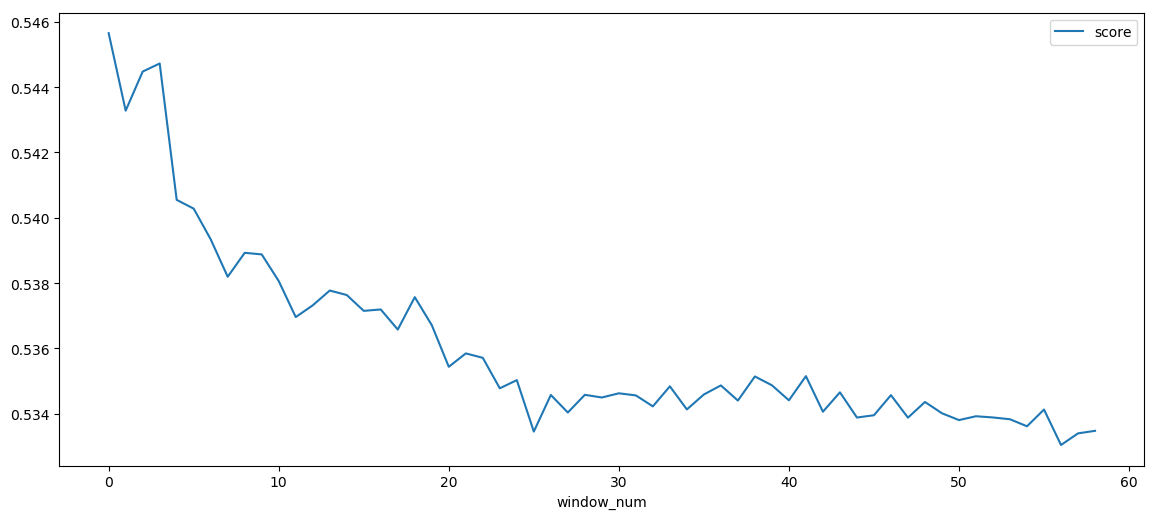

In [61]:
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure

%matplotlib inline

figure(num=None, figsize=(14, 6), dpi=100, facecolor='w', edgecolor='k')

ax = plt.gca()


score_record.plot(x='window_num',y='score',ax=ax)


plt.show()

In [ ]:
# for i in range(3):
#     train_feat_sub = make_feats_custom(date_add_days(start_date, i*(-7)),39)
#     train_feat = pd.concat([train_feat,train_feat_sub])

    
# test_feat = make_feats_custom(start_date,39)

In [ ]:
# for i in range(3):
#     train_feat_sub = make_feats_custom(date_add_days(start_date, i*(-7)),39)
#     print('train_feat_sub:')
# #     print(train_feat_sub)
#     print('dimension:',train_feat_sub.shape)
#     train_feat = pd.concat([train_feat,train_feat_sub])
#     print('train_feat:')
# #     print(train_feat)
#     print('dimension:',train_feat.shape)
    
# test_feat = make_feats_custom(date_add_days(start_date, 42),39)
# print('test_feat:')
# print('dimension:',test_feat.shape)

In [ ]:
# for i in range(58):
#     train_feat_sub = make_feats(date_add_days(start_date, i*(-7)),39)
#     train_feat = pd.concat([train_feat,train_feat_sub])
    
    
# for i in range(1,6):
#     train_feat_sub = make_feats(date_add_days(start_date,i*(7)),42-(i*7))
#     train_feat = pd.concat([train_feat,train_feat_sub])
# test_feat = make_feats(date_add_days(start_date, 42),39)






In [ ]:
# predictors = [f for f in test_feat.columns if f not in (['id','store_id','visit_date','end_date','air_area_name','visitors','month'])]

# params = {
#     'learning_rate': 0.02,
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'sub_feature': 0.7,
#     'num_leaves': 60,
#     'min_data': 100,
#     'min_hessian': 1,
#     'verbose': -1,
# }

# t0 = time.time()
# lgb_train = lgb.Dataset(train_feat[predictors], train_feat['visitors'])
# lgb_test = lgb.Dataset(test_feat[predictors], test_feat['visitors'])

# gbm = lgb.train(params,lgb_train,2300)
# pred = gbm.predict(test_feat[predictors])

# print('训练用时{}秒'.format(time.time() - t0))

In [ ]:
# subm = pd.DataFrame({'id':test_feat.store_id + '_' + test_feat.visit_date,'visitors':np.expm1(pred)})
# subm = submission[['id']].merge(subm,on='id',how='left').fillna(0)
# subm.to_csv(r'..\result\sub{}.csv'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')),
#                   index=False,  float_format='%.4f')

In [ ]:
# pd.Series(gbm.feature_importance(importance_type='gain'),
#           index=gbm.feature_name()).sort_values(ascending=False).head(100)